[-0.00826327 -0.01620496 -0.00907066 ... -0.07820387 -0.08929953
 -0.08369186]
1


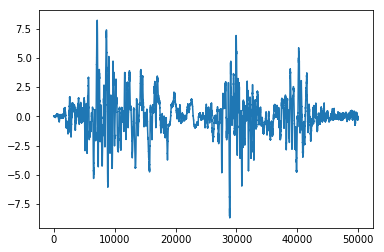

In [2]:
%matplotlib inline
import torch
import random
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import scipy.io as sio

data = sio.loadmat('../SBSB_6Khz_L23Mat_accZY_chunk_noTurn_noStatic.mat');


#loading the model

#trainSet function gives out a random range of 40000 values from a given trail_no. The trail_no is in range (0,1...19)
#depicting 20 rows in the mat file.

def trainSet(trail_no):
    flag = True
    range_start_no = 0
    trail_lane = data['L23MatChunk'][trail_no][0]
#     while(flag == True):
#         range_start_no = np.random.randint(0,51000) 
#         trail_lane = data['L23MatChunk'][trail_no][0]
#         if(len(trail_lane[0])-51001 >= range_start_no):
#             flag = False #break when you find the right range

    if trail_no < 10: #this label output is not used
        label = 0
    else:
        label = 1 

    input_range = trail_lane[0][range_start_no : range_start_no + 50000] 
    return input_range, label


#sample checking 
real_value, real_label = trainSet(12)
print(real_value)
print(real_label)


plt.plot(real_value)



In [3]:

#Designing the model

filters = 64

class ConvNet(nn.Module):
    def __init__(self):
        self.n_layers = 1
        self.input_size = 1
        #input matrix is given by B*S*I batch_first = true, 20 * 161 * 1
        #output matrix is given by 20 * 1 * 64
        self.hidden_size = self.output_dimen = 50
        self.batch_size = filters
        self.num_classes = 2
        self.seq_len = 161
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels = 1, out_channels = filters,kernel_size=25, stride=10),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.layer2 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=5),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.layer3 = nn.Sequential(
            nn.Conv1d(in_channels = filters, out_channels = filters, kernel_size=10, stride=3),
            nn.ReLU(),
            nn.BatchNorm1d(filters))
        self.avgLayer = nn.AvgPool1d(10, stride = 2)
        self.rnn = nn.RNN(input_size = 1, hidden_size = self.hidden_size, num_layers = self.n_layers, batch_first = True)
        self.fc1 = nn.Linear(self.hidden_size,2)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgLayer(out)
        out = out.view(filters,-1,1)
        print(out.shape)#output dimension at this stage 20 * 161 * 1(filters * 161 * I) of the shape B * S * I
        batch_size = out.size(0)
        hidden = self.init_hidden(batch_size)
        out, hidden = self.rnn(out, hidden)
        print(out.shape)
#         plt.subplot(2,1,2)
#         plt.plot(hidden.detach().numpy()[1][7])
        
#         out = hidden[1]
        out = self.fc1(out)        
#         out = self.fc1(out)
#         print(out.shape)
#         print(out.dtype)
        return out
    
    def init_hidden(self,batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)
        return Variable(hidden)


model = ConvNet()
opt = optim.Adam(model.parameters(), lr=0.1, betas=(0.9, 0.999))
criterion = nn.CrossEntropyLoss()
model

ConvNet(
  (layer1): Sequential(
    (0): Conv1d(1, 64, kernel_size=(25,), stride=(10,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1d(64, 64, kernel_size=(10,), stride=(5,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(10,), stride=(3,))
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (avgLayer): AvgPool1d(kernel_size=(10,), stride=(2,), padding=(0,))
  (rnn): RNN(1, 50, batch_first=True)
  (fc1): Linear(in_features=50, out_features=2, bias=True)
)

torch.Size([1, 1, 50000])
tensor([[[ 0.0180,  0.0330],
         [ 0.0211, -0.0260],
         [ 0.0053, -0.0331],
         ...,
         [ 0.0300, -0.0264],
         [ 0.0338, -0.0289],
         [ 0.0265, -0.0291]],

        [[ 0.0063,  0.0320],
         [ 0.0107, -0.0213],
         [-0.0018, -0.0330],
         ...,
         [ 0.0173, -0.0244],
         [ 0.0256, -0.0263],
         [ 0.0134, -0.0301]],

        [[ 0.0500,  0.0356],
         [ 0.0539, -0.0385],
         [ 0.0057, -0.0371],
         ...,
         [ 0.0553, -0.0282],
         [ 0.0912, -0.0326],
         [ 0.0563, -0.0452]],

        ...,

        [[ 0.0012,  0.0316],
         [-0.0003, -0.0198],
         [-0.0147, -0.0307],
         ...,
         [ 0.0379, -0.0276],
         [ 0.0378, -0.0289],
         [ 0.0350, -0.0293]],

        [[ 0.0034,  0.0318],
         [ 0.0068, -0.0203],
         [-0.0033, -0.0323],
         ...,
         [ 0.0212, -0.0262],
         [ 0.0215, -0.0266],
         [ 0.0221, -0.0268]],

        [[

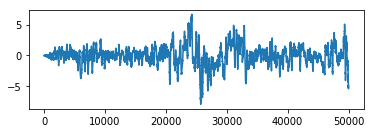

In [191]:
real_value, real_label = trainSet(0)
plt.subplot(2,1,1)
plt.plot(real_value)
real_value = torch.from_numpy(real_value)
real_value = real_value.view(1,1,50000)
real_value = real_value.float()
print(real_value.size())

output = model(real_value) 
print(output)
real_out = nn.functional.softmax(output, dim = 0)
print(real_out)


# m = nn.Softmax(dim = 1)
# # you softmax over the 2nd dimension
# input = torch.randn(1,2)
# output = m(input)
# print(input)
# print(output)

# loss = nn.CrossEntropyLoss()
# input = torch.tensor([[1,3]], dtype = torch.float)
# print(input.dtype)
# print(input.shape)
# target = torch.LongTensor([0])
# print(target)
# output = loss(input, target)
# print(output)
# # # output.backward()

# torch.max(2,1)






In [4]:


# Training the model

#the model is currently trained with all trails (20 in total) in order to improve accuracy

num_epochs = 50 #number of sets of 50000 values required to train the model
losses = []
for x in range(num_epochs):
    print(x)
    if x % 2 == 0:
        value = np.random.randint(0,10)
    else:
        value = np.random.randint(10,20) #Trail number is generated here using random function
    real_value, real_label = trainSet(value)

    real_value = torch.from_numpy(real_value)
    real_value = real_value.view(1,1,50000)
    real_value = Variable(real_value.float())
    if value < 10:
#         real_label1 = Variable(torch.LongTensor([1]))
        real_label1 = Variable(torch.ones(filters, dtype = torch.long))#target label is decided based on the trail number chosen by random function
    else:
#         real_label1 = Variable(torch.LongTensor([0]))
        real_label1 = Variable(torch.zeros(filters, dtype = torch.long))
    
    opt.zero_grad()
    
    output = model(real_value)
    
    loss = criterion(output, real_label1)
    
    loss.backward()
    
    opt.step()
    if(loss < 1.0):
        losses.append(loss.data.numpy()) 
    
plt.plot(losses)

0
torch.Size([64, 161, 1])
torch.Size([64, 161, 50])


ValueError: Expected target size (64, 2), got torch.Size([64])

In [193]:
#Testing the model
trial_no_2_test = np.random.randint(8,10)
trial_no_3_test = np.random.randint(18,20)
print(trial_no_2_test)
print(trial_no_3_test)


trial_no = (trial_no_2_test, trial_no_3_test)
trial_no_test = random.choice(trial_no)
print(type(trial_no_test))
print(trial_no_test)

real_value, real_label = trainSet(trial_no_test)

real_value = torch.from_numpy(real_value)
real_value = real_value.view(1,1,50000)
real_value = real_value.float()

output = model(real_value)
nn.Softmax(output)

print(output)



9
18
<class 'int'>
9
tensor([[[ 0.0140,  0.0326],
         [ 0.0139, -0.0248],
         [-0.0108, -0.0326],
         ...,
         [ 0.0201, -0.0268],
         [ 0.0177, -0.0256],
         [ 0.0129, -0.0260]],

        [[ 0.0033,  0.0317],
         [ 0.0019, -0.0206],
         [-0.0170, -0.0313],
         ...,
         [ 0.0157, -0.0262],
         [ 0.0218, -0.0244],
         [ 0.0274, -0.0281]],

        [[ 0.0539,  0.0359],
         [ 0.0661, -0.0393],
         [ 0.0304, -0.0391],
         ...,
         [-0.0024, -0.0227],
         [-0.0247, -0.0202],
         [-0.0776, -0.0205]],

        ...,

        [[ 0.0136,  0.0326],
         [ 0.0144, -0.0245],
         [-0.0144, -0.0333],
         ...,
         [ 0.0376, -0.0273],
         [ 0.0465, -0.0292],
         [ 0.0476, -0.0317]],

        [[ 0.0036,  0.0318],
         [ 0.0040, -0.0206],
         [-0.0083, -0.0314],
         ...,
         [ 0.0295, -0.0278],
         [ 0.0305, -0.0274],
         [ 0.0289, -0.0283]],

        [[ 0.01

In [108]:
value = 16
real_value, real_label = trainSet(value)
real_value = torch.from_numpy(real_value)
real_value = real_value.view(1,1,50000)
real_value = Variable(real_value.float())
output  = model(real_value)
real_out = nn.functional.softmax(output, dim = 0)
print(real_out)



0
(50000,)
tensor([[0.0512, 0.0490],
        [0.0512, 0.0491],
        [0.0512, 0.0490],
        [0.0372, 0.0482],
        [0.0515, 0.0496],
        [0.0512, 0.0490],
        [0.0377, 0.0464],
        [0.0522, 0.0503],
        [0.0512, 0.0490],
        [0.0512, 0.0490],
        [0.0518, 0.0534],
        [0.0513, 0.0492],
        [0.0512, 0.0490],
        [0.0512, 0.0491],
        [0.0517, 0.0497],
        [0.0496, 0.0605],
        [0.0521, 0.0501],
        [0.0513, 0.0492],
        [0.0519, 0.0501],
        [0.0522, 0.0509]], grad_fn=<SoftmaxBackward>)
